# Video Game Recommendations
> Loading steam video game data and performing EDA, ETL and training an implicit model based on WARP loss using LightFM library

- toc: true
- badges: true
- comments: true
- categories: [EDA, BPR, Visualization, TSNE, Games, Games&Entertainment, LightFM]
- image:

## Introduction

Gaming, being a fiercely competitive industry, your platform has to win its players with a different approach. We will build a system that upgrades your homepage or adjusts your app’s infinite scroll to individual tastes.

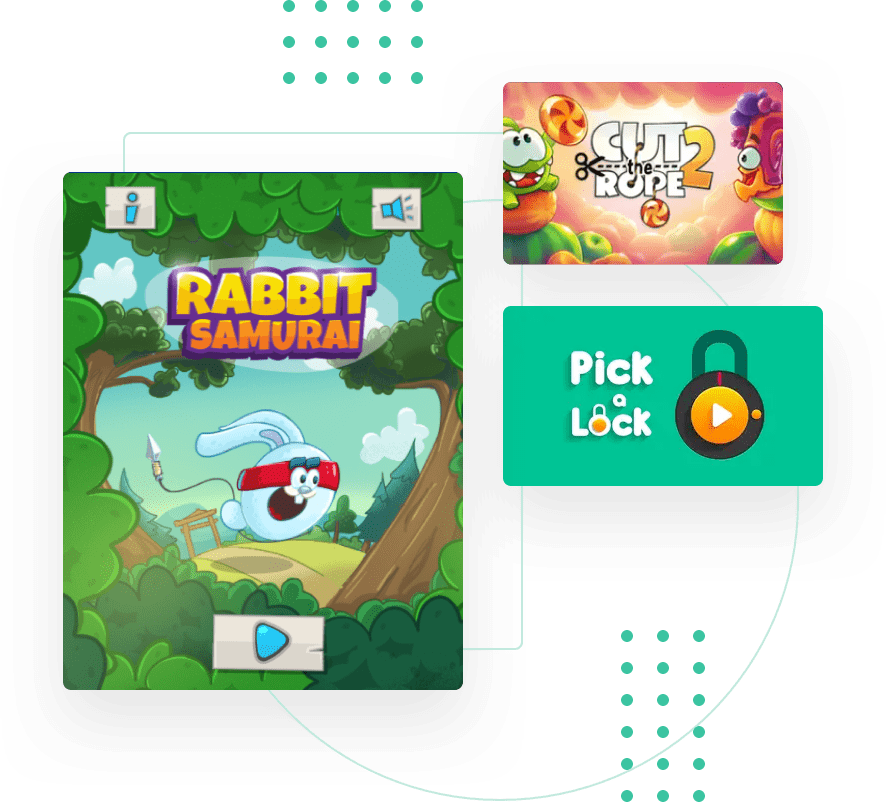

A video game recommendation engine suggests games using on-site **behavioural targeting.** This studies the user’s interactions, and suggests games based on similarities, but can also keep the players inspired with games from different genres. The recommender **initiates higher excitement about new games,** which is translated into **stronger customer loyalty** and increased time spent on the platform - factors that push sites through the ranks.

These type of recommendation engine analyzes item properties such as **title, genre, description, minimal age viewer** or **tags,** or interactions like **playtime, rating,** or **purchase.** You may also inform your players about new games to further increase CTR with **personalization of newsletters, emails,** or **push notifications.**

## Setup

In [ ]:
!pip install lightfm

In [2]:
import pandas as pd
import numpy as np
import pickle 
import ast
import json
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from scipy import sparse
from scipy.spatial import distance

from lightfm import LightFM
from sklearn.metrics.pairwise import cosine_similarity
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.keyedvectors import WordEmbeddingsKeyedVectors
import textwrap

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [14]:
!pip install -q watermark
%reload_ext watermark
%watermark -m -iv -u -t -d -p lightfm,gensim

Last updated: 2021-07-25 14:26:10

lightfm: 1.16
gensim : 3.6.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

IPython   : 5.5.0
numpy     : 1.19.5
pandas    : 1.1.5
seaborn   : 0.11.1
scipy     : 1.4.1
matplotlib: 3.2.2
json      : 2.0.9



## Data ingestion

Steam is the world's most popular PC Gaming hub, with over 6,000 games and a community of millions of gamers. With a massive collection that includes everything from AAA blockbusters to small indie titles, great discovery tools are a highly valuable asset for Steam.

**[Steam Video Game and Bundle Data](https://cseweb.ucsd.edu/~jmcauley/datasets.html#steam_data)**

These datasets contain reviews from the Steam video game platform, and information about which games were bundled together.

**citation**

1. Self-attentive sequential recommendation. Wang-Cheng Kang, Julian McAuley. ICDM, 2018. [pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/icdm18.pdf)
2. Item recommendation on monotonic behavior chains. Mengting Wan, Julian McAuley. RecSys, 2018. [pdf](http://cseweb.ucsd.edu/~jmcauley/pdfs/recsys18b.pdf)
3. Generating and personalizing bundle recommendations on Steam. Apurva Pathak, Kshitiz Gupta, Julian McAuley. SIGIR, 2017. [pdf](http://cseweb.ucsd.edu/~jmcauley/pdfs/sigir17.pdf)




In [ ]:
!wget http://deepx.ucsd.edu/public/jmcauley/steam/australian_users_items.json.gz
!gzip -d australian_users_items.json.gz

!wget http://cseweb.ucsd.edu/~wckang/steam_games.json.gz
!gzip -d steam_games.json.gz

# !wget http://deepx.ucsd.edu/public/jmcauley/steam/australian_user_reviews.json.gz
# !gzip -d australian_user_reviews.json.gz

--2021-07-25 11:00:55--  http://deepx.ucsd.edu/public/jmcauley/steam/australian_users_items.json.gz
Resolving deepx.ucsd.edu (deepx.ucsd.edu)... 169.228.63.216
Connecting to deepx.ucsd.edu (deepx.ucsd.edu)|169.228.63.216|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73574835 (70M) [application/octet-stream]
Saving to: ‘australian_users_items.json.gz’

australian_users_it 100%[===================>]  70.17M  33.4MB/s    in 2.1s    

2021-07-25 11:00:57 (33.4 MB/s) - ‘australian_users_items.json.gz’ saved [73574835/73574835]

--2021-07-25 11:01:01--  http://cseweb.ucsd.edu/~wckang/steam_games.json.gz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2740516 (2.6M) [application/x-gzip]
Saving to: ‘steam_games.json.gz’

steam_games.json.gz 100%[===================>]   2.61M  5.43MB/s    in 0.5s    

2021-07-25 11:01:02 (5.

### User-item Interactions

In [ ]:
with open('/content/australian_users_items.json') as f:
    lines = f.readlines()

lines[0]

'{\'user_id\': \'76561197970982479\', \'items_count\': 277, \'steam_id\': \'76561197970982479\', \'user_url\': \'http://steamcommunity.com/profiles/76561197970982479\', \'items\': [{\'item_id\': \'10\', \'item_name\': \'Counter-Strike\', \'playtime_forever\': 6, \'playtime_2weeks\': 0}, {\'item_id\': \'20\', \'item_name\': \'Team Fortress Classic\', \'playtime_forever\': 0, \'playtime_2weeks\': 0}, {\'item_id\': \'30\', \'item_name\': \'Day of Defeat\', \'playtime_forever\': 7, \'playtime_2weeks\': 0}, {\'item_id\': \'40\', \'item_name\': \'Deathmatch Classic\', \'playtime_forever\': 0, \'playtime_2weeks\': 0}, {\'item_id\': \'50\', \'item_name\': \'Half-Life: Opposing Force\', \'playtime_forever\': 0, \'playtime_2weeks\': 0}, {\'item_id\': \'60\', \'item_name\': \'Ricochet\', \'playtime_forever\': 0, \'playtime_2weeks\': 0}, {\'item_id\': \'70\', \'item_name\': \'Half-Life\', \'playtime_forever\': 0, \'playtime_2weeks\': 0}, {\'item_id\': \'130\', \'item_name\': \'Half-Life: Blue Shif

In [ ]:
len(lines)

88310

There are 88310 lines of data in this file, each representing a user.

In [ ]:
# Evaluate the first line
j = ast.literal_eval(lines[0])
j

{'items': [{'item_id': '10',
   'item_name': 'Counter-Strike',
   'playtime_2weeks': 0,
   'playtime_forever': 6},
  {'item_id': '20',
   'item_name': 'Team Fortress Classic',
   'playtime_2weeks': 0,
   'playtime_forever': 0},
  {'item_id': '30',
   'item_name': 'Day of Defeat',
   'playtime_2weeks': 0,
   'playtime_forever': 7},
  {'item_id': '40',
   'item_name': 'Deathmatch Classic',
   'playtime_2weeks': 0,
   'playtime_forever': 0},
  {'item_id': '50',
   'item_name': 'Half-Life: Opposing Force',
   'playtime_2weeks': 0,
   'playtime_forever': 0},
  {'item_id': '60',
   'item_name': 'Ricochet',
   'playtime_2weeks': 0,
   'playtime_forever': 0},
  {'item_id': '70',
   'item_name': 'Half-Life',
   'playtime_2weeks': 0,
   'playtime_forever': 0},
  {'item_id': '130',
   'item_name': 'Half-Life: Blue Shift',
   'playtime_2weeks': 0,
   'playtime_forever': 0},
  {'item_id': '300',
   'item_name': 'Day of Defeat: Source',
   'playtime_2weeks': 0,
   'playtime_forever': 4733},
  {'item

In [ ]:
lines_list = []
for l in lines:
    _x = '[' + l + ']'
    _x =  ast.literal_eval(_x)
    lines_list.extend(_x)

with open(f'data.json', 'w') as json_file:
    json.dump(lines_list, json_file)

We now have a `.json` file that we can easily view as a Pandas DataFrame.

In [ ]:
df = pd.read_json("data.json")
df.head()

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982480,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864384,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712560,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445856,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099488,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


In [ ]:
df.to_parquet('interactions.parquet.gzip', compression='gzip')

In [ ]:
!mv /content/interactions.parquet.gzip ./steam
!git status
!git add . && git commit -m 'commit' && git push origin steam

### Item Metadata

In [ ]:
with open('steam_games.json') as f:
    lines = f.readlines()

lines[0]

"{u'publisher': u'Kotoshiro', u'genres': [u'Action', u'Casual', u'Indie', u'Simulation', u'Strategy'], u'app_name': u'Lost Summoner Kitty', u'title': u'Lost Summoner Kitty', u'url': u'http://store.steampowered.com/app/761140/Lost_Summoner_Kitty/', u'release_date': u'2018-01-04', u'tags': [u'Strategy', u'Action', u'Indie', u'Casual', u'Simulation'], u'discount_price': 4.49, u'reviews_url': u'http://steamcommunity.com/app/761140/reviews/?browsefilter=mostrecent&p=1', u'specs': [u'Single-player'], u'price': 4.99, u'early_access': False, u'id': u'761140', u'developer': u'Kotoshiro'}\n"

In [ ]:
# Get number of lines
len(lines)

32135

There are 32135 lines, each representing a different game.

In [ ]:
# evaluate the first string
j = ast.literal_eval(lines[0])
j

{'app_name': 'Lost Summoner Kitty',
 'developer': 'Kotoshiro',
 'discount_price': 4.49,
 'early_access': False,
 'genres': ['Action', 'Casual', 'Indie', 'Simulation', 'Strategy'],
 'id': '761140',
 'price': 4.99,
 'publisher': 'Kotoshiro',
 'release_date': '2018-01-04',
 'reviews_url': 'http://steamcommunity.com/app/761140/reviews/?browsefilter=mostrecent&p=1',
 'specs': ['Single-player'],
 'tags': ['Strategy', 'Action', 'Indie', 'Casual', 'Simulation'],
 'title': 'Lost Summoner Kitty',
 'url': 'http://store.steampowered.com/app/761140/Lost_Summoner_Kitty/'}

In [ ]:
lines_list = []
for l in lines:
    _x = '[' + l + ']'
    _x =  ast.literal_eval(_x)
    lines_list.extend(_x)

with open(f'meta.json', 'w') as json_file:
    json.dump(lines_list, json_file)

We now have a `.json` file that we can easily view as a Pandas DataFrame.

In [ ]:
df = pd.read_json("meta.json")
df.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140.0,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400.0,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570.0,NaN,NaN,NaN


In [ ]:
df.dtypes

publisher          object
genres             object
app_name           object
title              object
url                object
release_date       object
tags               object
discount_price    float64
reviews_url        object
specs              object
price              object
early_access         bool
id                float64
developer          object
sentiment          object
metascore          object
dtype: object

In [ ]:
df.price = df.price.astype('str')
df.metascore = df.metascore.astype('str')
df.dtypes

publisher          object
genres             object
app_name           object
title              object
url                object
release_date       object
tags               object
discount_price    float64
reviews_url        object
specs              object
price              object
early_access         bool
id                float64
developer          object
sentiment          object
metascore          object
dtype: object

In [ ]:
df.to_parquet('items.parquet.gzip', compression='gzip')

In [ ]:
%cd /content/reco-data
!mv /content/items.parquet.gzip ./steam
!git status
!git add . && git commit -m 'commit' && git push origin steam

## Transformation

### Data loading

In [2]:
!wget https://github.com/sparsh-ai/reco-data/raw/steam/steam/items.parquet.gzip
!wget https://github.com/sparsh-ai/reco-data/raw/steam/steam/interactions.parquet.gzip

--2021-07-25 13:07:55--  https://github.com/sparsh-ai/reco-data/raw/steam/steam/items.parquet.gzip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sparsh-ai/reco-data/steam/steam/items.parquet.gzip [following]
--2021-07-25 13:07:55--  https://raw.githubusercontent.com/sparsh-ai/reco-data/steam/steam/items.parquet.gzip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2432340 (2.3M) [application/octet-stream]
Saving to: ‘items.parquet.gzip’

items.parquet.gzip  100%[===================>]   2.32M  --.-KB/s    in 0.1s    

2021-07-25 13:07:55 (22.0 MB/s) - ‘items.parquet.gzip’ saved [2432340/2432340]

In [7]:
df = pd.read_parquet("items.parquet.gzip")
df.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140.0,Kotoshiro,None,nan
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,nan
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,nan
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400.0,彼岸领域,None,nan
4,None,None,Log Challenge,None,http://store.steampowered.com/app/773570/Log_C...,None,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570.0,None,None,nan


In [8]:
useritems = pd.read_parquet("interactions.parquet.gzip")
useritems.head()

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982480,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864384,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712560,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445856,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099488,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


In [9]:
useritems['item_id'] = useritems['items'].apply(lambda x: [x [index]['item_id'] for index, _ in enumerate(x)])
useritems.head()

,user_id,items_count,steam_id,user_url,items,item_id
0,76561197970982479,277,76561197970982480,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik...","[10, 20, 30, 40, 50, 60, 70, 130, 300, 240, 38..."
1,js41637,888,76561198035864384,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik...","[10, 80, 100, 300, 30, 40, 60, 240, 280, 360, ..."
2,evcentric,137,76561198007712560,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest...","[1200, 1230, 1280, 1520, 220, 320, 340, 360, 3..."
3,Riot-Punch,328,76561197963445856,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik...","[10, 20, 30, 40, 50, 60, 70, 130, 80, 100, 300..."
4,doctr,541,76561198002099488,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea...","[300, 20, 50, 70, 130, 10, 30, 40, 60, 80, 100..."


### Transformation

In [10]:
# Add a column with substitute user_id, counter
useritems['uid'] = np.arange(len(useritems))

# numgames dataframe for later use
numgames = useritems[['user_id', 'items_count']]

# Take relevant columns
useritems = useritems[['uid', 'item_id']]

# Check
useritems.head()

,uid,item_id
0,0,"[10, 20, 30, 40, 50, 60, 70, 130, 300, 240, 38..."
1,1,"[10, 80, 100, 300, 30, 40, 60, 240, 280, 360, ..."
2,2,"[1200, 1230, 1280, 1520, 220, 320, 340, 360, 3..."
3,3,"[10, 20, 30, 40, 50, 60, 70, 130, 80, 100, 300..."
4,4,"[300, 20, 50, 70, 130, 10, 30, 40, 60, 80, 100..."


In [11]:
# Explode item_ids into seperate rows
lst_col = 'item_id'
useritems = pd.DataFrame({col:np.repeat(useritems[col].values, useritems[lst_col].str.len())
                              for col in useritems.columns.difference([lst_col])
                        }).assign(**{lst_col:np.concatenate(useritems[lst_col].values)})[useritems.columns.tolist()]
useritems

,uid,item_id
0,0,10
1,0,20
2,0,30
3,0,40
4,0,50
...,...,...
5153204,88308,346330
5153205,88308,373330
5153206,88308,388490
5153207,88308,521570


In [12]:
# Add binary owned column
useritems['owned'] = np.ones(shape = useritems.shape[0])

# Change item_id to int
useritems['item_id'] = useritems['item_id'].astype(int)

# Rename column to match
useritems = useritems.rename(columns={'item_id': 'id'})

useritems.head()

,uid,id,owned
0,0,10,1.0
1,0,20,1.0
2,0,30,1.0
3,0,40,1.0
4,0,50,1.0


In [13]:
# Merge useritems and games data dataframes
alldata = pd.merge(useritems, df, on = 'id')

# Drop entries with no title
datawithnames = alldata.dropna(axis=0, subset=['title'])

# Get relevant columns for recommendation engine
recdata = datawithnames[['uid','id','owned']]
recdata.head()

,uid,id,owned
0,0,10,1.0
1,1,10,1.0
2,3,10,1.0
3,4,10,1.0
4,10,10,1.0


### Data checkpointing

In [14]:
df.to_parquet('gamesdata.parquet.gzip', compression='gzip')
datawithnames.to_parquet('mergeddata.parquet.gzip', compression='gzip')
numgames.to_parquet('numgames.parquet.gzip', compression='gzip')
recdata.to_parquet('recdata.parquet.gzip', compression='gzip')

## EDA

### Data loading

In [2]:
gamesdata = pd.read_parquet('gamesdata.parquet.gzip')
gamesdata.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140.0,Kotoshiro,None,nan
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,nan
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,nan
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400.0,彼岸领域,None,nan
4,None,None,Log Challenge,None,http://store.steampowered.com/app/773570/Log_C...,None,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570.0,None,None,nan


In [3]:
mergeddata = pd.read_parquet('mergeddata.parquet.gzip')
mergeddata.head()

,uid,id,owned,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,developer,sentiment,metascore
0,0,10,1.0,Valve,[Action],Counter-Strike,Counter-Strike,http://store.steampowered.com/app/10/CounterSt...,2000-11-01,"[Action, FPS, Multiplayer, Shooter, Classic, T...",NaN,http://steamcommunity.com/app/10/reviews/?brow...,"[Multi-player, Valve Anti-Cheat enabled]",9.99,False,Valve,Overwhelmingly Positive,88
1,1,10,1.0,Valve,[Action],Counter-Strike,Counter-Strike,http://store.steampowered.com/app/10/CounterSt...,2000-11-01,"[Action, FPS, Multiplayer, Shooter, Classic, T...",NaN,http://steamcommunity.com/app/10/reviews/?brow...,"[Multi-player, Valve Anti-Cheat enabled]",9.99,False,Valve,Overwhelmingly Positive,88
2,3,10,1.0,Valve,[Action],Counter-Strike,Counter-Strike,http://store.steampowered.com/app/10/CounterSt...,2000-11-01,"[Action, FPS, Multiplayer, Shooter, Classic, T...",NaN,http://steamcommunity.com/app/10/reviews/?brow...,"[Multi-player, Valve Anti-Cheat enabled]",9.99,False,Valve,Overwhelmingly Positive,88
3,4,10,1.0,Valve,[Action],Counter-Strike,Counter-Strike,http://store.steampowered.com/app/10/CounterSt...,2000-11-01,"[Action, FPS, Multiplayer, Shooter, Classic, T...",NaN,http://steamcommunity.com/app/10/reviews/?brow...,"[Multi-player, Valve Anti-Cheat enabled]",9.99,False,Valve,Overwhelmingly Positive,88
4,10,10,1.0,Valve,[Action],Counter-Strike,Counter-Strike,http://store.steampowered.com/app/10/CounterSt...,2000-11-01,"[Action, FPS, Multiplayer, Shooter, Classic, T...",NaN,http://steamcommunity.com/app/10/reviews/?brow...,"[Multi-player, Valve Anti-Cheat enabled]",9.99,False,Valve,Overwhelmingly Positive,88


In [4]:
numgames = pd.read_parquet('numgames.parquet.gzip')
numgames.head()

,user_id,items_count
0,76561197970982479,277
1,js41637,888
2,evcentric,137
3,Riot-Punch,328
4,doctr,541


In [ ]:
# Load numgames data
numgames = pd.read_csv('numgames.csv', index_col = 0)
numgames.head()

,user_id,items_count
0,76561197970982479,277
1,js41637,888
2,evcentric,137
3,Riot-Punch,328
4,doctr,541


### Release date

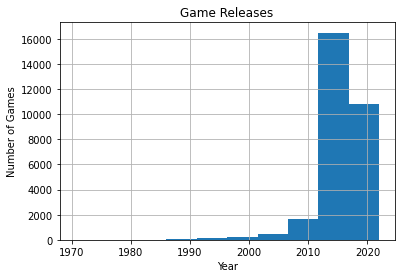

In [24]:
# Select entries where release date is not null
data = gamesdata[gamesdata['release_date'].notnull()]

# Replace strings which are not of the format xxxx-xx-xx with None
data['release_date'] = data['release_date'].map(lambda x : x if x[-3] == '-'else None)

# Select entries where release date is not null
data = data[data['release_date'].notnull()]

# Convert to DateTime 
data['release_date'] = pd.to_datetime(data['release_date'])

# Check 
data['release_date'].describe()

# Plot histogram of release date feat
data['release_date'].hist()
plt.title('Game Releases')
plt.ylabel('Number of Games')
plt.xlabel('Year')
plt.show()

We see that our data contains games ranging from 1970 up to predicted release date of December 2021.

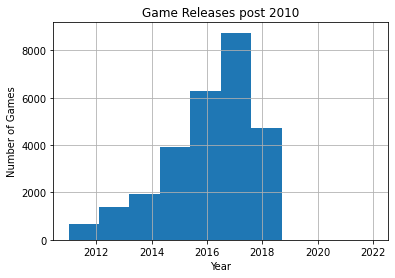

In [25]:
# Focus on post 2010
recentgames = data[data['release_date'].dt.year > 2010]

recentgames['release_date'].hist()
plt.title('Game Releases post 2010')
plt.ylabel('Number of Games')
plt.xlabel('Year')
plt.show()

Let's see which months are most popular for new releases.

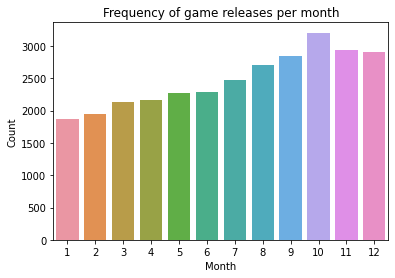

In [26]:
# Create month feature
data['release_month'] = data['release_date'].dt.month

# Plot countplot using Seaborn
sns.countplot(x = data['release_month'], data = data)
plt.title('Frequency of game releases per month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

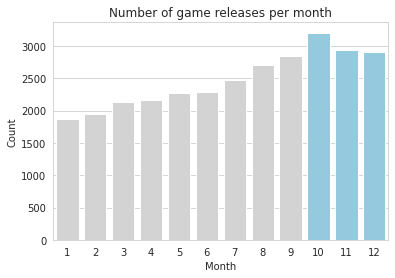

In [28]:
# Countplot of sale month

# define palette to highlight best months to buy house
custompalette = {release_month: "skyblue" if (release_month == 10 or release_month == 11 or release_month == 12 ) else "lightgrey" \
                 for release_month in data['release_month'].unique()}

with sns.axes_style("whitegrid"):
    sns.countplot(x = data['release_month'], palette = custompalette, data = data)
plt.title('Number of game releases per month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.savefig('month.pdf', bbox_inches = "tight")

We see that October, November and December have the highest number of game releases. Let's look at quarters now.

In [29]:
# Define function to determine quarter
def quarter(month):
    ''' Returns quarter in which month falls'''
    if 1 <= month <= 3:
        quarter = 'Q1'
    elif 4 <= month <= 6:
        quarter = 'Q2'
    elif 7 <= month <= 9:
        quarter = 'Q3'
    else:
        quarter = 'Q4'
    return quarter

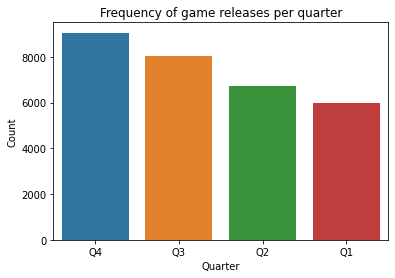

In [30]:
# Create quarter feature
data['release_quarter'] = data['release_month'].apply(quarter)

# Plot countplot using Seaborn
sns.countplot(x = data['release_quarter'], data = data, 
              order = data['release_quarter'].value_counts().index)
plt.title('Frequency of game releases per quarter')
plt.xlabel('Quarter')
plt.ylabel('Count')
plt.show()

**Recommendation:**

Q4 and in particular the month of October sees the most new games released. We would recommend ensuring advertisement deals are priced at a premium during this period.

Finally, let's look at release date for the user-item data.

In [31]:
# Create copy to work with
releasedatedata = mergeddata.copy()

# Select entries where release date is not null
releasedatedata = releasedatedata[releasedatedata['release_date'].notnull()]

# Replace strings which are not of the format xxxx-xx-xx with None
releasedatedata['release_date'] = releasedatedata['release_date'].map(lambda x : x if x[-3] == '-'else None)

# Select entries where release date is not null
releasedatedata = releasedatedata[releasedatedata['release_date'].notnull()]

# Convert to DateTime 
releasedatedata['release_date'] = pd.to_datetime(releasedatedata['release_date'])

# Check 
releasedatedata['release_date'].describe()

count                 4191586
unique                   2649
top       2012-08-21 00:00:00
freq                    44434
first     1983-06-19 00:00:00
last      2018-12-01 00:00:00
Name: release_date, dtype: object

Of course, we now have plenty of duplicate entries. However we note that the games span 1983 to 2018.

### Game library size

In [33]:
# View head
numgames.head()

,user_id,items_count
0,76561197970982479,277
1,js41637,888
2,evcentric,137
3,Riot-Punch,328
4,doctr,541


In [32]:
# Get summary statistics
numgames['items_count'].describe()

count    88310.000000
mean        58.353629
std        122.312095
min          0.000000
25%          3.000000
50%         26.000000
75%         73.000000
max       7762.000000
Name: items_count, dtype: float64

We have data for 88310 unique steam users. We note that the minimum number of games owned is 0 whereas the maximum is 7762. The average number of games owned is 58.

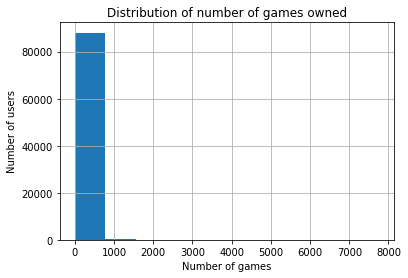

In [34]:
# Plot distribution of `items_count`
numgames['items_count'].hist()
plt.title('Distribution of number of games owned')
plt.xlabel('Number of games')
plt.ylabel('Number of users')
plt.show()

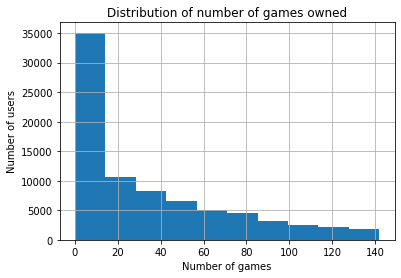

In [35]:
# Plot distribution of items_count within 90% centile
numgames[numgames['items_count'] < numgames['items_count'].quantile(0.90)].hist()
plt.title('Distribution of number of games owned')
plt.xlabel('Number of games')
plt.ylabel('Number of users')
plt.show()

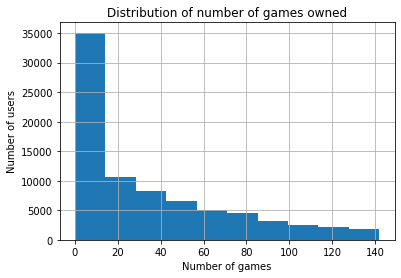

In [37]:
# Plot distribution of items_count within 90% centile
numgames[numgames['items_count'] < numgames['items_count'].quantile(0.90)].hist()
plt.title('Distribution of number of games owned')
plt.xlabel('Number of games')
plt.ylabel('Number of users')
plt.savefig('numgames.pdf', bbox_inches = "tight")
plt.show()

**Recommendation:**

Focus campaign on users who have below the average number of games of 58. These users are more likely to find games they do not own which appeal.

### Game Price

In [38]:
# Create a copy to work with
gamesprice = gamesdata.copy()

# Get statistics and type
gamesprice['price'].describe()

count     32135
unique      163
top        4.99
freq       4278
Name: price, dtype: object

We see that the values are of type `object`. 

From viewing the head above, we noticed the presence of the string `Free To Play`. Let us replace that value with 0. 

We will also iterate and replace all strings we find with 0.

In [47]:
gamesprice.price = gamesprice.price.replace(to_replace = 'Free To Play', value = 0)
gamesprice.price = gamesprice.price.replace(to_replace = 'Free to Play', value = 0)
gamesprice.price = gamesprice.price.replace(to_replace = 'Free', value = 0)
gamesprice.price = gamesprice.price.replace(to_replace = 'Free Demo', value = 0)
gamesprice.price = gamesprice.price.replace(to_replace = 'Play for Free!', value = 0)
gamesprice.price = gamesprice.price.replace(to_replace = 'Install Now', value = 0)
gamesprice.price = gamesprice.price.replace(to_replace = 'Play WARMACHINE: Tactics Demo', value = 0)
gamesprice.price = gamesprice.price.replace(to_replace = 'Free Mod', value = 0)
gamesprice.price = gamesprice.price.replace(to_replace = 'Install Theme', value = 0)
gamesprice.price = gamesprice.price.replace(to_replace = 'Third-party', value = 0)
gamesprice.price = gamesprice.price.replace(to_replace = 'Play Now', value = 0)
gamesprice.price = gamesprice.price.replace(to_replace = 'Free HITMAN™ Holiday Pack', value = 0)
gamesprice.price = gamesprice.price.replace(to_replace = 'Play the Demo', value = 0)
gamesprice.price = gamesprice.price.replace(to_replace = 'Starting at $499.00', value = 0)
gamesprice.price = gamesprice.price.replace(to_replace = 'Starting at $449.00', value = 0)
gamesprice.price = gamesprice.price.replace(to_replace = 'Free to Try', value = 0)
gamesprice.price = gamesprice.price.replace(to_replace = 'Free Movie', value = 0)
gamesprice.price = gamesprice.price.replace(to_replace = 'Free to Use', value = 0)

In [48]:
# Convert to float
gamesprice['price'] = gamesprice['price'].astype(float)

In [49]:
# Get summary statistics
gamesprice['price'].describe()

count    30758.000000
mean         8.866855
std         15.903457
min          0.000000
25%          2.990000
50%          4.990000
75%          9.990000
max        995.000000
Name: price, dtype: float64

We see that 75% of games are under $10! Looks like the majority of games are cheap.

In [50]:
belowcentile = gamesprice[gamesprice['price'] < gamesprice['price'].quantile(0.99)]

In [51]:
belowcentile['price'].describe()

count    30440.000000
mean         7.879879
std          8.100161
min          0.000000
25%          2.990000
50%          4.990000
75%          9.990000
max         49.990000
Name: price, dtype: float64

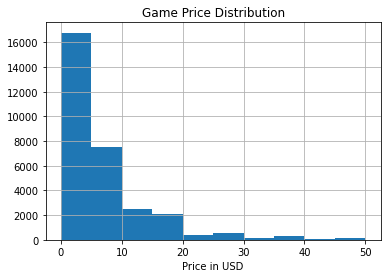

In [103]:
belowcentile['price'].hist()
plt.xlabel('Price in USD')
plt.title('Game Price Distribution')
plt.savefig('price.pdf', bbox_inches = "tight")
plt.show()

**Recommendation**: Focus on volume of sales as the 75% of games are below $10. Highlights the importance of bundles for higher single transactions and where the user may not be interested in all games but still think it worthwhile.

### Game genre

In [53]:
gamesdata.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140.0,Kotoshiro,None,nan
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,nan
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,nan
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400.0,彼岸领域,None,nan
4,None,None,Log Challenge,None,http://store.steampowered.com/app/773570/Log_C...,None,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570.0,None,None,nan


In [72]:
# Create copy
gamegenres = gamesdata.copy()

# Drop NaN
gamegenres = gamegenres[gamegenres['genres'].notnull()]

# Get unique lists
genres = list(gamegenres['genres'].astype('str').unique())

# View first 5
genres[:5]

["['Action' 'Casual' 'Indie' 'Simulation' 'Strategy']",
 "['Free to Play' 'Indie' 'RPG' 'Strategy']",
 "['Casual' 'Free to Play' 'Indie' 'Simulation' 'Sports']",
 "['Action' 'Adventure' 'Casual']",
 "['Action' 'Adventure' 'Simulation']"]

In [67]:
# Combine all strings
allgenres = ','.join(genres)

# Preview first 100 characters
allgenres[:100]

"['Action' 'Casual' 'Indie' 'Simulation' 'Strategy'],['Free to Play' 'Indie' 'RPG' 'Strategy'],['Casu"

In [68]:
# Replace chars
allgenres = allgenres.replace("' '",",").replace("\n","").replace("[","").replace("]", "").replace("'", "").replace(" ","")

# Check
allgenres[:100]

'Action,Casual,Indie,Simulation,Strategy,FreetoPlay,Indie,RPG,Strategy,Casual,FreetoPlay,Indie,Simula'

In [69]:
# Split
splitgenres = allgenres.split(',')
splitgenres[:5]

['Action', 'Casual', 'Indie', 'Simulation', 'Strategy']

In [70]:
# Use set to obtain unique values
uniquegenres = set(splitgenres)
uniquegenres

{'Accounting',
 'Action',
 'Adventure',
 'Animation&amp;Modeling',
 'AudioProduction',
 'AudioProductionDesign&amp;Illustration',
 'Casual',
 'Design&amp;Illustration',
 'Design&amp;IllustrationSoftwareTraining',
 'Design&amp;IllustrationUtilities',
 'EarlyAccess',
 'Education',
 'EducationPhotoEditing',
 'EducationSoftwareTraining',
 'EducationUtilities',
 'FreetoPlay',
 'Indie',
 'IndieMassivelyMultiplayer',
 'MassivelyMultiplayer',
 'MassivelyMultiplayerEarlyAccess',
 'MassivelyMultiplayerRPG',
 'MassivelyMultiplayerRacing',
 'MassivelyMultiplayerSimulation',
 'PhotoEditing',
 'PhotoEditingSoftwareTraining',
 'PhotoEditingUtilities',
 'PhotoEditingVideoProduction',
 'RPG',
 'RPGEarlyAccess',
 'RPGSimulation',
 'RPGStrategy',
 'Racing',
 'RacingRPG',
 'RacingSimulation',
 'Simulation',
 'SimulationEarlyAccess',
 'SimulationSports',
 'SimulationStrategy',
 'SoftwareTraining',
 'SoftwareTrainingUtilities',
 'Sports',
 'SportsEarlyAccess',
 'SportsStrategy',
 'Strategy',
 'StrategyEarly

In [73]:
# Create columns with genres
for genre in uniquegenres:
    gamegenres[genre] = 0
    
# Split genres in genres column
gamegenres['genres'] = gamegenres['genres'].astype('str').map(lambda x : x.replace("' '",",").replace("\n","").replace("[","").replace("]", "").replace("'", "").replace(" ","").split(','))

# Map to columns - set to 1 if genre applies
for index, genres in enumerate(gamegenres['genres']):
    for genre in genres:
        gamegenres.loc[index,genre] = 1
        
# Visuale the new columns
gamegenres.head(2)  

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore,MassivelyMultiplayerEarlyAccess,RacingSimulation,VideoProduction,Education,EducationSoftwareTraining,AudioProduction,Indie,Strategy,FreetoPlay,SimulationStrategy,VideoProductionWebPublishing,RPGSimulation,SimulationSports,Design&amp;IllustrationUtilities,Animation&amp;Modeling,Design&amp;Illustration,IndieMassivelyMultiplayer,SimulationEarlyAccess,UtilitiesWebPublishing,PhotoEditing,MassivelyMultiplayer,StrategyEarlyAccess,Sports,Utilities,Adventure,PhotoEditingUtilities,UtilitiesVideoProduction,RacingRPG,RPGStrategy,PhotoEditingSoftwareTraining,AudioProductionDesign&amp;Illustration,SportsEarlyAccess,Design&amp;IllustrationSoftwareTraining,Racing,SportsStrategy,RPG,Action,SoftwareTrainingUtilities,RPGEarlyAccess,EducationPhotoEditing,EducationUtilities,UtilitiesEarlyAccess,MassivelyMultiplayerRacing,Accounting,EarlyAccess,WebPublishing,Casual,SoftwareTraining,MassivelyMultiplayerSimulation,MassivelyMultiplayerRPG,PhotoEditingVideoProduction,Simulation
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140.0,Kotoshiro,None,nan,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,"Making Fun, Inc.","[FreetoPlay, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,nan,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
gamegenres.columns

Index(['publisher', 'genres', 'app_name', 'title', 'url', 'release_date',
       'tags', 'discount_price', 'reviews_url', 'specs', 'price',
       'early_access', 'id', 'developer', 'sentiment', 'metascore',
       'MassivelyMultiplayerEarlyAccess', 'RacingSimulation',
       'VideoProduction', 'Education', 'EducationSoftwareTraining',
       'AudioProduction', 'Indie', 'Strategy', 'FreetoPlay',
       'SimulationStrategy', 'VideoProductionWebPublishing', 'RPGSimulation',
       'SimulationSports', 'Design&amp;IllustrationUtilities',
       'Animation&amp;Modeling', 'Design&amp;Illustration',
       'IndieMassivelyMultiplayer', 'SimulationEarlyAccess',
       'UtilitiesWebPublishing', 'PhotoEditing', 'MassivelyMultiplayer',
       'StrategyEarlyAccess', 'Sports', 'Utilities', 'Adventure',
       'PhotoEditingUtilities', 'UtilitiesVideoProduction', 'RacingRPG',
       'RPGStrategy', 'PhotoEditingSoftwareTraining',
       'AudioProductionDesign&amp;Illustration', 'SportsEarlyAccess',
   

In [87]:
# Start with empty dictionary
genredict = {}

# Get genre columns
genrecols = gamegenres.iloc[:, 16:].columns

# Go through each column and sum it
for col in genrecols:
    genredict[col] = gamegenres[col].sum()
        
# sort dictionary based on counts, ascending order so reverse = True    
sortedgenresdict = {keys: values for keys, values in \
                        sorted(genredict.items(), key = lambda item: item[1], reverse = True)}
sortedgenresdict = sorted(sortedgenresdict.items(), key=lambda kv:(kv[1], kv[0]), reverse=True)  

sortedgenresdict

[('Indie', 15852.0),
 ('Action', 11321.0),
 ('Casual', 8282.0),
 ('Adventure', 8243.0),
 ('Strategy', 6862.0),
 ('Simulation', 6623.0),
 ('RPG', 5425.0),
 ('FreetoPlay', 2031.0),
 ('EarlyAccess', 1413.0),
 ('Sports', 1209.0),
 ('Racing', 1079.0),
 ('MassivelyMultiplayer', 1079.0),
 ('Design&amp;Illustration', 455.0),
 ('Utilities', 313.0),
 ('WebPublishing', 262.0),
 ('Animation&amp;Modeling', 183.0),
 ('VideoProduction', 105.0),
 ('AudioProduction', 92.0),
 ('Education', 71.0),
 ('PhotoEditing', 65.0),
 ('SoftwareTraining', 54.0),
 ('EducationSoftwareTraining', 43.0),
 ('SimulationStrategy', 32.0),
 ('SportsStrategy', 27.0),
 ('RPGStrategy', 19.0),
 ('StrategyEarlyAccess', 17.0),
 ('SimulationSports', 16.0),
 ('MassivelyMultiplayerRPG', 16.0),
 ('SimulationEarlyAccess', 14.0),
 ('RPGSimulation', 10.0),
 ('EducationUtilities', 8.0),
 ('RPGEarlyAccess', 7.0),
 ('Accounting', 7.0),
 ('IndieMassivelyMultiplayer', 6.0),
 ('VideoProductionWebPublishing', 5.0),
 ('UtilitiesVideoProduction', 

We see that Indie is the most popular genre, followed by Action. On the other end of the spectrum, there are few entries relating to Photo Editing and only 7 for Accounting. This makes sense as Steam is a gaming platform, and so photo editing or accounting software doesn't really belong.

### Game tags

In [89]:
# Create copy
gametags = gamesdata.copy()

# Drop NaN
gametags = gamegenres[gamegenres['tags'].notnull()]

# Get unique lists
tags = list(gametags['tags'].astype('str').unique())

# View first 5
tags[:5]

["['Strategy' 'Action' 'Indie' 'Casual' 'Simulation']",
 "['Free to Play' 'Strategy' 'Indie' 'RPG' 'Card Game' 'Trading Card Game'\n 'Turn-Based' 'Fantasy' 'Tactical' 'Dark Fantasy' 'Board Game' 'PvP' '2D'\n 'Competitive' 'Replay Value' 'Character Customization'\n 'Female Protagonist' 'Difficult' 'Design & Illustration']",
 "['Free to Play' 'Simulation' 'Sports' 'Casual' 'Indie' 'Multiplayer']",
 "['Action' 'Adventure' 'Casual']",
 "['Action' 'Adventure' 'Simulation' 'FPS' 'Shooter' 'Third-Person Shooter'\n 'Sniper' 'Third Person']"]

In [90]:
# Combine all strings
alltags = ','.join(tags)

# Preview first 100 characters
alltags[:100]

"['Strategy' 'Action' 'Indie' 'Casual' 'Simulation'],['Free to Play' 'Strategy' 'Indie' 'RPG' 'Card G"

In [91]:
# Replace chars
alltags = alltags.replace("' '",",").replace("\n","").replace("["," ").replace("]", "").replace("'", "")

# Check
alltags[:100]

' Strategy,Action,Indie,Casual,Simulation, Free to Play,Strategy,Indie,RPG,Card Game,Trading Card Gam'

In [92]:
# Split
splittags = alltags[1:].split(',')
splittags[:5]

['Strategy', 'Action', 'Indie', 'Casual', 'Simulation']

In [93]:
# Use set to obtain unique values
uniquetags = set(splittags)
len(uniquetags)

7729

### Top publishers

In [94]:
# Select entries where publisher is non-null
data = gamesdata[gamesdata['publisher'].notnull()]

In [95]:
# Create dictionary
game_publishers = {}
for publisher in list(data['publisher']):
    if not publisher in game_publishers:
        game_publishers[publisher] = 1
    else:
        game_publishers[publisher] += 1

In [96]:
# Get top 10 publishers
top10_publishers = dict(Counter(game_publishers).most_common(10))
top10_publishers

{'Activision': 202,
 'Big Fish Games': 195,
 'Degica': 286,
 'Dovetail Games - Flight': 220,
 'Dovetail Games - Trains': 360,
 'KISS ltd': 189,
 'KOEI TECMO GAMES CO., LTD.': 208,
 'Paradox Interactive': 271,
 'SEGA': 251,
 'Ubisoft': 385}

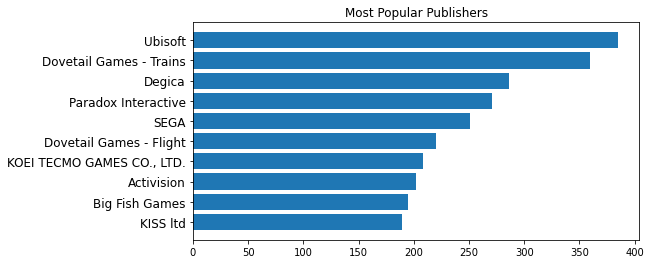

In [97]:
# Prepare for bar chart plot
top10_publishers = dict(sorted(Counter(game_publishers).most_common(10), key=lambda x:x[1]))

# Plots most popular publishers
fig = plt.figure(figsize = (8,4))
plt.barh(range(len(top10_publishers)), list(top10_publishers.values()), align='center')
plt.yticks(range(len(top10_publishers)), list(top10_publishers.keys()), fontsize=12)
plt.title("Most Popular Publishers", fontsize=12, fontweight= 22)
plt.show()

## Modeling

### Utils

In [5]:
def create_interaction_matrix(df,user_col, item_col, rating_col, norm= False, threshold = None):
    '''
    Creates an interaction matrix DataFrame
    Arguments:
        df = Pandas DataFrame containing user-item interactions
        user_col = column name containing user's identifier
        item_col = column name containing item's identifier
        rating col = column name containing user rating on given item
        norm (optional) = True if a normalization of ratings is needed
        threshold (required if norm = True) = value above which the rating is favorable
    Returns:
        Pandas DataFrame with user-item interactions
    '''
    interactions = df.groupby([user_col, item_col])[rating_col] \
            .sum().unstack().reset_index(). \
            fillna(0).set_index(user_col)
    if norm:
        interactions = interactions.applymap(lambda x: 1 if x > threshold else 0)
    return interactions

def create_user_dict(interactions):
    '''
    Creates a user dictionary based on their index and number in interaction dataset
    Arguments:
        interactions - DataFrame with user-item interactions
    Returns:
        user_dict - Dictionary containing interaction_index as key and user_id as value
    '''
    user_id = list(interactions.index)
    user_dict = {}
    counter = 0 
    for i in user_id:
        user_dict[i] = counter
        counter += 1
    return user_dict

def create_item_dict(df,id_col,name_col):
    '''
    Creates an item dictionary based on their item_id and item name
    Arguments: 
        - df = Pandas dataframe containing item information
        - id_col = column name containing unique identifier for an item
        - name_col = column name containing name of the item
    Returns:
        item_dict = Dictionary containing item_id as key and item_name as value
    '''
    item_dict ={}
    for i in range(df.shape[0]):
        item_dict[(df.loc[i,id_col])] = df.loc[i,name_col]
    return item_dict

def run_model(interactions, n_components=30, loss='warp', epoch=30, n_jobs = 4):
    '''
    Runs matrix-factorization model using LightFM
    Arguments:
        interactions = Pandas DataFrame containing user-item interactions
        n_components = number of desired embeddings to create to define item and user
        loss = loss function other options are logistic, brp
        epoch = number of epochs to run 
        n_jobs = number of cores used for execution 
    Returns:
        Model = Trained model
    '''
    x = sparse.csr_matrix(interactions.values)
    model = LightFM(no_components= n_components, loss=loss)
    model.fit(x,epochs=epoch,num_threads = n_jobs)
    return model

def get_recs(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,num_items = 10, show_known = True, show_recs = True):
    '''
    Produces user recommendations
    Arguments:
        model = Trained matrix factorization model
        interactions = dataset used for training the model
        user_id = user ID for which we need to generate recommendation
        user_dict = Dictionary containing interaction_index as key and user_id as value
        item_dict = Dictionary containing item_id as key and item_name as value
        threshold = value above which the rating is favorable in new interaction matrix
        num_items = Number of recommendations to provide
        show_known (optional) - if True, prints known positives
        show_recs (optional) - if True, prints list of N recommended items  which user hopefully will be interested in
    Returns:
        list of titles user_id is predicted to be interested in 
    '''
    n_users, n_items = interactions.shape
    # Get value for user_id using dictionary
    user_x = user_dict[user_id]
    # Generate predictions
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    # Get top predictions
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    # Get list of known values
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    # Ensure predictions are not already known
    scores = [x for x in scores if x not in known_items]
    # Take required number of items from prediction list
    return_score_list = scores[0:num_items]
    # Convert from item id to item name using item_dict
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    
    if show_known == True:
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1
            
    if show_recs == True:
        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1
    return scores

def create_item_emdedding_matrix(model,interactions):
    '''
    Creates item-item distance embedding matrix
    Arguments:
        model = trained matrix factorization model
        interactions = dataset used for training the model
    Returns:
        Pandas dataframe containing cosine distance matrix between items
    '''
    df_item_norm_sparse = sparse.csr_matrix(model.item_embeddings)
    similarities = cosine_similarity(df_item_norm_sparse)
    item_emdedding_matrix = pd.DataFrame(similarities)
    item_emdedding_matrix.columns = interactions.columns
    item_emdedding_matrix.index = interactions.columns
    
    return item_emdedding_matrix

def get_item_recs(item_emdedding_matrix, item_id, 
                             item_dict, n_items = 10, show = True):
    '''
    Function to create item-item recommendation
    Arguments: 
        - item_emdedding_distance_matrix = Pandas dataframe containing cosine distance matrix b/w items
        - item_id  = item ID for which we need to generate recommended items
        - item_dict = Dictionary type input containing item_id as key and item_name as value
        - n_items = Number of items needed as an output
    Returns:
        - recommended_items = List of recommended items
    '''
    recommended_items = list(pd.Series(item_emdedding_matrix.loc[item_id,:]. \
                                  sort_values(ascending = False).head(n_items+1). \
                                  index[1:n_items+1]))
    if show == True:
        print("Item of interest: {0}".format(item_dict[item_id]))
        print("Similar items:")
        counter = 1
        for i in recommended_items:
            print(str(counter) + '- ' +  item_dict[i])
            counter+=1
    return recommended_items

### Data loading

In [15]:
recdata = pd.read_parquet("recdata.parquet.gzip")
recdata

,uid,id,owned
0,0,10,1.0
1,1,10,1.0
2,3,10,1.0
3,4,10,1.0
4,10,10,1.0
...,...,...,...
4294251,67381,444770,1.0
4294252,74089,375450,1.0
4294253,85030,353390,1.0
4294254,86026,354280,1.0


In [16]:
gamesdata = pd.read_parquet("gamesdata.parquet.gzip")
gamesdata.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140.0,Kotoshiro,None,nan
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,nan
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,nan
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400.0,彼岸领域,None,nan
4,None,None,Log Challenge,None,http://store.steampowered.com/app/773570/Log_C...,None,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570.0,None,None,nan


### Create interaction matrix

We will create an interactions matrix using the user-item data. This is done using the `create_interaction_matrix` function, which can be found in `resources.py`.

In [ ]:
# Use create_interaction_matrix function
interactions = create_interaction_matrix(df = recdata,
                                         user_col = 'uid',
                                         item_col = 'id',
                                         rating_col = 'owned')
interactions.shape

From the shape, we note that we have 69277 unique users and 8791 different games represented.

In [ ]:
# Preview head
interactions.head()

id,10,20,30,40,50,60,70,80,130,220,...,526790,527340,527440,527510,527520,527810,527890,527900,528660,530720
uid,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train test split

We will manually split the interactions matrix into a training set and test set for evaluation purposes.

In [ ]:
# Get number of users
len(interactions)

69277

We choose to have roughly 80% of our data as training and 20% as test.

In [ ]:
# Establish number of users in train/test sets

train_num = round((80/100)*len(interactions),0)
print(f'We desire {train_num} users in our training set.')

test_num = len(interactions)-train_num
print(f'We desire {test_num} users in our test set.')

We desire 55422.0 users in our training set.
We desire 13855.0 users in our test set.


In [ ]:
# Define train and test sets
train = interactions[:55422]
test = interactions[55422:]

### Create user dictionary

We will create a dictionary which matches users with another a counter `id`, by using the `create_user_dict` function, which can be found in `resources.py`.

In [ ]:
# Create user dictionary using helper function
user_dict = create_user_dict(interactions=interactions)

### Create item dictionary

We will create a dictionary which matches each game `id` with its `title`, by using the `create_item_dict`function, which can be found in `resources.py`.

In [ ]:
# Create game dictionary using helper function
games_dict = create_item_dict(df = gamesdata, id_col = 'id', name_col = 'title')

### Create sparse matrices

We will transform the interaction into a sparse matrix, to make computations efficient.

For the trainset, we simply use the `sparse.csr_matrix()` function.

With the test set, due to a known issue, we need to add additional rows so that the number of rows matches the trains set.

In [ ]:
# Create sparse matrices for evaluation 
train_sparse = sparse.csr_matrix(train.values)

#Add X users to Test so that the number of rows in Train match Test
N = train.shape[0] #Rows in Train set
n,m = test.shape #Rows & columns in Test set
z = np.zeros([(N-n),m]) #Create the necessary rows of zeros with m columns
#test = test.toarray() #Temporarily convert Test into a numpy array
test = np.vstack((test,z)) #Vertically stack Test on top of the blank users
test_sparse = sparse.csr_matrix(test) #Convert back to sparse

### Modelling using LightFM

To build our recommendation engine, we will make use of the LightFM library.

### WARP loss model

For the first model, we will choose the loss function to be WARP.

In [ ]:
# Instantiate and fit model
mf_model_warp = run_model(interactions = train,
                 n_components = 30,
                 loss = 'warp',
                 epoch = 30,
                 n_jobs = 4)

In [ ]:
# Get precision
train_precision = precision_at_k(mf_model_warp, train_sparse, k=10).mean()
test_precision = precision_at_k(mf_model_warp, test_sparse, k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.66, test 0.19.


We note that the precision score for the test is low, but this is expected due to the sheer volume of games available and the scarcity of interactions.

In [ ]:
# Get AUC
train_auc = auc_score(mf_model_warp, train_sparse).mean()
test_auc = auc_score(mf_model_warp, test_sparse).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

AUC: train 0.99, test 0.94.


The AUC score is very high, which is great.

### BPR loss model

We will compare the model above with a model using BPR as the loss function.

In [ ]:
# Instantiate and fit model
mf_model_bpr = run_model(interactions = train,
                 n_components = 30,
                 loss = 'bpr',
                 epoch = 30,
                 n_jobs = 4)

In [ ]:
# Get precision
train_precision = precision_at_k(mf_model_bpr, train_sparse, k=10).mean()
test_precision = precision_at_k(mf_model_bpr, test_sparse, k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.75, test 0.15.


Again, we note that the precision score for the test is low, but this is expected due to the sheer volume of games available and the scarcity of interactions.

In [ ]:
# Get AUC
train_auc = auc_score(mf_model_bpr, train_sparse).mean()
test_auc = auc_score(mf_model_bpr, test_sparse).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

AUC: train 0.97, test 0.73.


Again, the AUC score is good, though significantly lower for the test set compare to the train set.

Based on these two models, we will keep WARP as the loss function due to better performance all round.

### Adjust num of components

The `n_components` parameter controlls the number of embeddings (dimension of the features in the latent space.)

We will vary this number, lowering it to `10` first and then increasing it to `50` to see how this affects model performance.

In [ ]:
# Instantiate and fit model
mf_model_warp_2 = run_model(interactions = train,
                 n_components = 10,
                 loss = 'warp',
                 epoch = 30,
                 n_jobs = 4)

In [ ]:
# Get precision
train_precision = precision_at_k(mf_model_warp_2, train_sparse, k=10).mean()
test_precision = precision_at_k(mf_model_warp_2, test_sparse, k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.60, test 0.22.


In [ ]:
# Get AUC
train_auc = auc_score(mf_model_warp_2, train_sparse).mean()
test_auc = auc_score(mf_model_warp_2, test_sparse).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

AUC: train 0.98, test 0.95.


In [ ]:
# Instantiate and fit model
mf_model_warp_50 = run_model(interactions = train,
                 n_components = 50,
                 loss = 'warp',
                 epoch = 30,
                 n_jobs = 4)

In [ ]:
# Get precision
train_precision = precision_at_k(mf_model_warp_50, train_sparse, k=10).mean()
test_precision = precision_at_k(mf_model_warp_50, test_sparse, k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.70, test 0.18.


In [ ]:
# Get AUC
train_auc = auc_score(mf_model_warp_50, train_sparse).mean()
test_auc = auc_score(mf_model_warp_50, test_sparse).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

AUC: train 0.99, test 0.94.


Overall, we see that varying the `n_components` feature has little impact on overall model performance.

### Final model

We train the chosen model (WARP loss and 30 components) on the full interactions matrix.

In [ ]:
# Instantiate and fit model on full interactions set
mf_model = run_model(interactions = interactions,
                 n_components = 30,
                 loss = 'warp',
                 epoch = 30,
                 n_jobs = 4)

### Embeddings

Before using our model to provide recommendations, let us explore the embedding space.

### Retrieve embeddings matrix

In [ ]:
# Get embeddings
embeddings = mf_model.item_embeddings
embeddings

array([[ 0.24690884, -0.60024494, -0.34321675, ...,  0.39954203,
        -0.34470356,  0.6996237 ],
       [ 1.013957  , -1.0958432 , -1.1673098 , ...,  1.5129188 ,
        -1.0025263 ,  0.8605353 ],
       [ 1.419911  , -0.76011163, -1.4812998 , ...,  1.0426521 ,
        -0.58840156,  0.6917034 ],
       ...,
       [ 0.37666148,  0.06383109, -0.37983808, ...,  0.01275835,
        -0.647543  , -0.5578531 ],
       [ 0.31045482,  0.4377617 , -0.30335838, ..., -0.27258068,
        -0.25924444, -0.29798537],
       [ 0.8851168 , -0.1208554 , -0.43298256, ..., -0.08469868,
        -0.27769536, -0.29746038]], dtype=float32)

In [ ]:
# View shape
embeddings.shape

(8791, 30)

Our embeddings array has 8791 rows, with each row representing a game. Each row has 30 numbers, representing the components of our game embeddings. This is because we set `n_components` to be 30 in our model.

Let's investigate a sample game vector.

In [ ]:
embeddings[0]

array([ 0.24690884, -0.60024494, -0.34321675,  0.18282364, -1.2370884 ,
       -0.5774308 , -0.35622823,  0.54888403,  0.28783935, -0.828556  ,
        0.35981768, -0.5272332 , -0.5084524 , -0.7428038 ,  0.12216418,
        0.47244594, -0.52268714, -0.39862898, -1.503811  ,  1.1665981 ,
       -0.24812686, -1.1389667 ,  1.6629837 , -0.37311617,  0.00638717,
       -0.07876787, -0.08371691,  0.39954203, -0.34470356,  0.6996237 ],
      dtype=float32)

To retrieve the name of the game, we first look up the game id using our interactions matrix and then obtain the name using the games dictionary.

In [ ]:
firstgameid = interactions.columns[0]
games_dict[firstgameid]

'Counter-Strike'

### Pair similarity

Let us examine how close or distant pairs of games are in the embedding space. The embedding space can be interpreted as a distance metric and so we would expect similar games to have similar vectors.

Our first game will be `Counter-Strike` as seen above. 

We would expect it to be similar to `Left 4 Dead 2`.

In [ ]:
# Get data for both games
gamesdata[(gamesdata['title']=='Counter-Strike') | (gamesdata['title']=='Left 4 Dead 2') ]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31529,Valve,['Action'],Left 4 Dead 2,Left 4 Dead 2,http://store.steampowered.com/app/550/Left_4_D...,2009-11-16,"['Zombies', 'Co-op', 'FPS', 'Multiplayer', 'Ac...",NaN,http://steamcommunity.com/app/550/reviews/?bro...,"['Single-player', 'Multi-player', 'Co-op', 'St...",19.99,False,550.0,Valve,Overwhelmingly Positive,89.0
32106,Valve,['Action'],Counter-Strike,Counter-Strike,http://store.steampowered.com/app/10/CounterSt...,2000-11-01,"['Action', 'FPS', 'Multiplayer', 'Shooter', 'C...",NaN,http://steamcommunity.com/app/10/reviews/?brow...,"['Multi-player', 'Valve Anti-Cheat enabled']",9.99,False,10.0,Valve,Overwhelmingly Positive,88.0


Let us look at the vectors for these two games.

In [ ]:
# Set index for Counter-Strike
cs_index = 0

# Obtain embeddings vector 
cs_vector = embeddings[cs_index]

cs_vector

array([ 0.24690884, -0.60024494, -0.34321675,  0.18282364, -1.2370884 ,
       -0.5774308 , -0.35622823,  0.54888403,  0.28783935, -0.828556  ,
        0.35981768, -0.5272332 , -0.5084524 , -0.7428038 ,  0.12216418,
        0.47244594, -0.52268714, -0.39862898, -1.503811  ,  1.1665981 ,
       -0.24812686, -1.1389667 ,  1.6629837 , -0.37311617,  0.00638717,
       -0.07876787, -0.08371691,  0.39954203, -0.34470356,  0.6996237 ],
      dtype=float32)

In [ ]:
# Retrieve game id for LFD2
lfd2_id = gamesdata[gamesdata['title']=='Left 4 Dead 2']['id'].values[0]

# Obtain index for Squad in interactions matrix
lfd2_index = list(interactions.columns).index(lfd2_id)

# Obtain embeddings vector
lfd2_vector = embeddings[lfd2_index]

lfd2_vector

array([-0.47054738, -0.09553305,  0.3035873 , -0.04027557, -0.30052912,
       -0.04460974, -0.430263  ,  0.3894665 , -0.16456904, -0.3458131 ,
        0.02933553,  0.08092439, -0.44579884,  0.5828283 ,  0.12577946,
        0.48369217, -0.32890347,  0.08169048,  0.05243007, -0.24915524,
        0.33367637, -0.5070402 ,  0.1763026 , -0.35381997, -0.1324723 ,
        0.40483642,  0.12619357,  0.31072268,  0.07221867,  0.37287298],
      dtype=float32)

To assign a single value to the similarity between these two vectors, we calculate the distance between them. Let us first compute the Euclidean distance.

In [ ]:
# Compute Euclidean distance
distance.euclidean(cs_vector, lfd2_vector)

3.6518919467926025

Let us compare this figure with a pair of games we believe to be very different.

In [ ]:
# Get data for both games
gamesdata[(gamesdata['title']=='Counter-Strike') | (gamesdata['title']=='The Room') ]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
2472,Fireproof Games,"['Adventure', 'Indie']",The Room,The Room,http://store.steampowered.com/app/288160/The_R...,2014-07-28,"['Puzzle', 'Adventure', 'Point & Click', 'Indi...",NaN,http://steamcommunity.com/app/288160/reviews/?...,"['Single-player', 'Steam Achievements', 'Steam...",4.99,False,288160.0,Fireproof Games,Overwhelmingly Positive,73.0
32106,Valve,['Action'],Counter-Strike,Counter-Strike,http://store.steampowered.com/app/10/CounterSt...,2000-11-01,"['Action', 'FPS', 'Multiplayer', 'Shooter', 'C...",NaN,http://steamcommunity.com/app/10/reviews/?brow...,"['Multi-player', 'Valve Anti-Cheat enabled']",9.99,False,10.0,Valve,Overwhelmingly Positive,88.0


In [ ]:
# Retrieve game id for The Room
room_id = gamesdata[gamesdata['title']=='The Room']['id'].values[0]

# Obtain index for Squad in interactions matrix
room_index = list(interactions.columns).index(room_id)

# Obtain embeddings vector
room_vector = embeddings[room_index]

room_vector

array([ 0.18102524,  0.03450267, -0.49559462,  0.52064276, -0.13829972,
       -0.6893131 , -0.10249795, -0.6738657 , -0.13697192,  0.5107905 ,
       -0.69814545, -0.17198849,  0.00435968,  0.63461906,  0.9719135 ,
        0.17290895,  0.71184224, -0.12161961,  0.43436503, -0.6281764 ,
       -0.11903907, -0.1752168 ,  0.03669906, -0.4266076 , -0.34094498,
        0.25538862,  0.28402406,  0.42189395, -0.7988556 ,  0.30456227],
      dtype=float32)

In [ ]:
# Compute Euclidean distance
distance.euclidean(cs_vector, room_vector)

4.734748363494873

When looking at the similarity of embeddings, it is more common to look at cosine similarity. Cosine similarity ranges between -1 and 1 based on the angle between the vectors. From this figure, cosine distance is defined as 1 minus the cosine similarity and therefore a value between 0 and 2.

In [ ]:
print(f'Cosine distance between Counter Strike and Left 4 Dead 2: {distance.cosine(cs_vector, lfd2_vector)}')
print(f'Cosine distance between Counter Strike and The Room: {distance.cosine(cs_vector, room_vector)}')

Cosine distance between Counter Strike and Left 4 Dead 2: 0.7091985046863556
Cosine distance between Counter Strike and The Room: 1.108935683965683


### Exploring embeddings with Gensim

In [ ]:
# Set embedding size
embedding_size = embeddings.shape[1]

# Create instance
kv = WordEmbeddingsKeyedVectors(embedding_size)

# Get list of game names in correct order to match embeddings
gameslist = []
for game_id in interactions.columns:
    name = games_dict[game_id]
    gameslist.append(name)
    
# Add to kv
kv.add(gameslist, embeddings )

Let us obtain the games closest to `Counter-Strike`.

In [ ]:
# Get games closest to Counter-Strike
kv.most_similar('Counter-Strike')

[('Counter-Strike: Condition Zero', 0.9947258234024048),
 ('Day of Defeat', 0.8795914649963379),
 ('Ricochet', 0.8772425651550293),
 ('Deathmatch Classic', 0.8760509490966797),
 ('Counter-Strike: Source', 0.7674432992935181),
 ('Team Fortress Classic', 0.7315292954444885),
 ('Day of Defeat: Source', 0.7312443852424622),
 ('Half-Life: Source', 0.7133708596229553),
 ('Half-Life: Blue Shift', 0.7080429196357727),
 ('Half-Life: Opposing Force', 0.7068089246749878)]

In [ ]:
# Get games closest to Left 4 Dead 2
kv.most_similar('Left 4 Dead 2')

[('PAYDAY™ The Heist', 0.8530459403991699),
 ('Sniper Elite: Nazi Zombie Army', 0.7959485054016113),
 ('Defence Alliance 2', 0.7898242473602295),
 ('Killing Floor', 0.7879504561424255),
 ('Sniper Elite V2', 0.7798643112182617),
 ('Killing Floor 2', 0.7442474365234375),
 ('Sniper Elite: Nazi Zombie Army 2', 0.7353828549385071),
 ('Red Orchestra 2: Heroes of Stalingrad with Rising Storm',
  0.7210018038749695),
 ('Dead Rising 2: Off the Record', 0.6979968547821045),
 ('Borderlands 2', 0.6945492029190063)]

In [ ]:
# Get games closest to The Room
kv.most_similar('The Room')

[('Contrast', 0.657098650932312),
 ('The Room Two', 0.6547083854675293),
 ('Homesick', 0.6430520415306091),
 ('Max: The Curse of Brotherhood', 0.6386649012565613),
 ('Among the Sleep - Enhanced Edition', 0.6373388767242432),
 ('Refunct', 0.6364350318908691),
 ('The Vanishing of Ethan Carter', 0.6215814352035522),
 ('The Tiny Bang Story', 0.6027441024780273),
 ('The Talos Principle', 0.5984798669815063),
 ('The Collider', 0.5833116769790649)]

In [ ]:
# Get games closest to RollerCoaster Tycoon
kv.most_similar('RollerCoaster Tycoon®: Deluxe')

[('RollerCoaster Tycoon® 2: Triple Thrill Pack', 0.961402952671051),
 ('RollerCoaster Tycoon® 3: Platinum', 0.7569327354431152),
 ('Microsoft Flight Simulator X: Steam Edition', 0.6815069913864136),
 ('The Sims™ 3', 0.652948796749115),
 ('Domestic Dog', 0.6336350440979004),
 ('Farming Simulator 2013 Modding Tutorials', 0.6317681074142456),
 ('Game Dev Tycoon', 0.6245903968811035),
 ('Poly Bridge', 0.6192208528518677),
 ("Chip's Challenge 2", 0.6178507208824158),
 ('Thrillville®: Off the Rails™', 0.6116662621498108)]

In [ ]:
# Get games closest to Dishonored
kv.most_similar('Dishonored')

[('BioShock Infinite', 0.8288344740867615),
 ('Far Cry 3', 0.8255295157432556),
 ('Wolfenstein: The New Order', 0.8041225075721741),
 ('Far Cry 3 - Blood Dragon', 0.8033542633056641),
 ('Middle-earth™: Shadow of Mordor™', 0.7888890504837036),
 ('The Witcher 2: Assassins of Kings Enhanced Edition', 0.7851611375808716),
 ('Tomb Raider', 0.785068929195404),
 ('METAL GEAR RISING: REVENGEANCE', 0.7362707853317261),
 ('Max Payne 3', 0.726372241973877),
 ('Tom Clancy’s Splinter Cell Blacklist', 0.7235777378082275)]

In [ ]:
# Get games closest to The Jackbox Party Pack
kv.most_similar('The Jackbox Party Pack')

[('Drawful 2', 0.8083049058914185),
 ('The Jackbox Party Pack 2', 0.7723324298858643),
 ('Quiplash', 0.7602243423461914),
 ('N++ (NPLUSPLUS)', 0.7241716384887695),
 ('Ultimate Chicken Horse', 0.7005695700645447),
 ("LEGO® MARVEL's Avengers", 0.6627241969108582),
 ('Zoombinis', 0.6528385877609253),
 ('Gang Beasts', 0.6466518640518188),
 ('Duck Game', 0.6404242515563965),
 ('A Hat in Time', 0.6267029047012329)]

In [ ]:
# Get games closest to American Truck Simulator
kv.most_similar('American Truck Simulator')

[('Farming Simulator 15', 0.8262251615524292),
 ('Bus Simulator 16', 0.8033299446105957),
 ('Automation - The Car Company Tycoon Game', 0.7880554795265198),
 ('OMSI 2: Steam Edition', 0.7836086750030518),
 ('BeamNG.drive', 0.7558793425559998),
 ('Euro Truck Simulator 2', 0.7491252422332764),
 ('The Crew™', 0.7279947400093079),
 ('Rugby League Live 3', 0.7190185785293579),
 ('SPINTIRES™', 0.7140108346939087),
 ('F1 2014', 0.7113802433013916)]

In [ ]:
def plot_similar(item, ax, topn=5):
    '''
    Plots a bar chart of similar items
    Arguments:
        - item, string
        - ax, axes on which to plot
        - topn (default = 5) number of similar items to plot
    '''
    sim = kv.most_similar(item, topn=topn)[::-1]
    y = np.arange(len(sim))
    w = [t[1] for t in sim]
    ax.barh(y, w)
    left = min(.6, min(w))
    ax.set_xlim(right=1.0, left=left)
    # Split long titles over multiple lines
    labels = [textwrap.fill(t[0] , width=24)
              for t in sim]
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.set_title(item)   

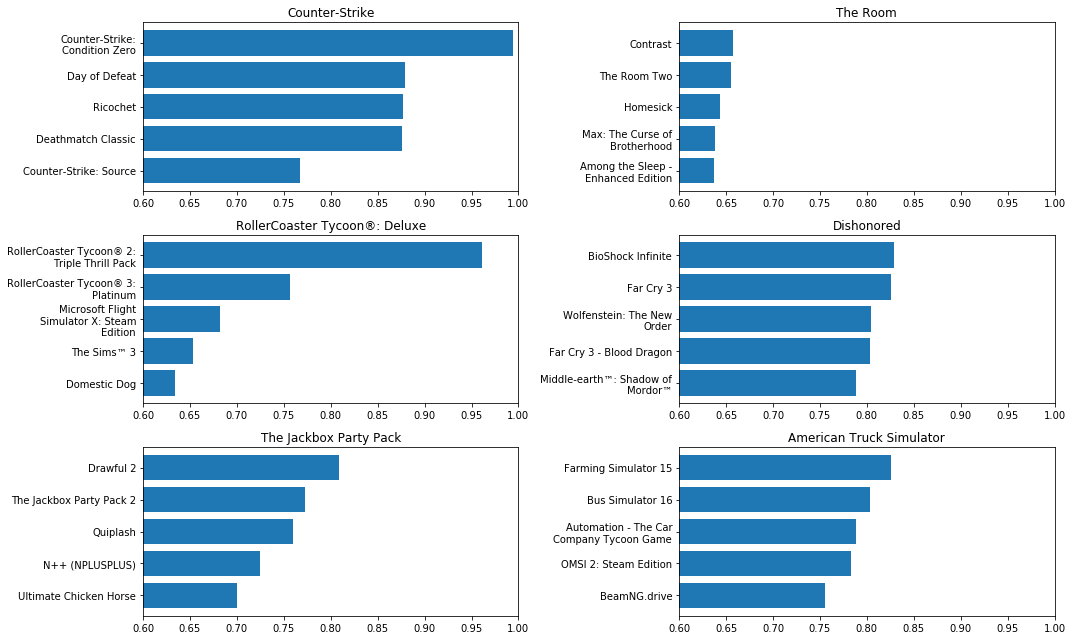

In [ ]:
# Define list of games to visualise similar items for
games = ['Counter-Strike', 'The Room', 'RollerCoaster Tycoon®: Deluxe', 'Dishonored', 
         'The Jackbox Party Pack', 'American Truck Simulator']

# Set figure/axes to have 3 rows with 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 9))

# Loop through games and use plot_similar function 
for game, ax in zip(games, axes.flatten()):
    plot_similar(game, ax)
    
fig.tight_layout()

### Visualizing embeddings with t-SNE

We will use the t-SNE algorithm to visualise embeddings, going from a 30-dimensional space (number of components) to a 2-dimensional space.

In [ ]:
# Instantialte tsne, specify cosine metric
tsne = TSNE(random_state = 0, n_iter = 1000, metric = 'cosine')

# Fit and transform
embeddings2d = tsne.fit_transform(embeddings)

Let's create a DataFrame with the game name and 2d embeddings.

In [ ]:
# Create DF
embeddingsdf = pd.DataFrame()

# Add game names
embeddingsdf['game'] = gameslist

# Add x coordinate
embeddingsdf['x'] = embeddings2d[:,0]

# Add y coordinate
embeddingsdf['y'] = embeddings2d[:,1]

# Check
embeddingsdf.head()

,game,x,y
0,Counter-Strike,16.987724,66.246674
1,Team Fortress Classic,15.679153,66.504463
2,Day of Defeat,16.470198,66.311852
3,Deathmatch Classic,16.463135,66.319084
4,Half-Life: Opposing Force,15.628381,66.494621


Let's draw a scatterplot of our games, using the 2D mapping we created.

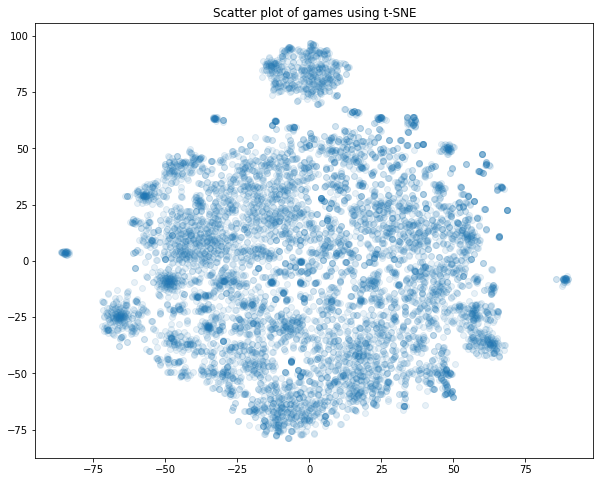

In [ ]:
# Set figsize
fig, ax = plt.subplots(figsize=(10,8))

# Scatter points, set alpha low to make points translucent
ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.1)

plt.title('Scatter plot of games using t-SNE')

plt.show()

It is hard to judge anything by the shape of the plot alone. However as a check, let us ensure that games we expect to be close are indeed close in this 2-dimensional space.

Let's leave `Counter-Strike` alone and look for the `Roller Coaster Tycoon` games.

In [ ]:
match = embeddingsdf[embeddingsdf.game.str.contains('RollerCoaster')]
match

,game,x,y
70,RollerCoaster Tycoon® 3: Platinum,-5.914381,34.996365
2875,RollerCoaster Tycoon World™,-19.753864,3.131330
2955,RollerCoaster Tycoon®: Deluxe,-6.502711,35.681301
2956,RollerCoaster Tycoon® 2: Triple Thrill Pack,-6.471217,35.654629


We will highlight the above games on our scatter plot.

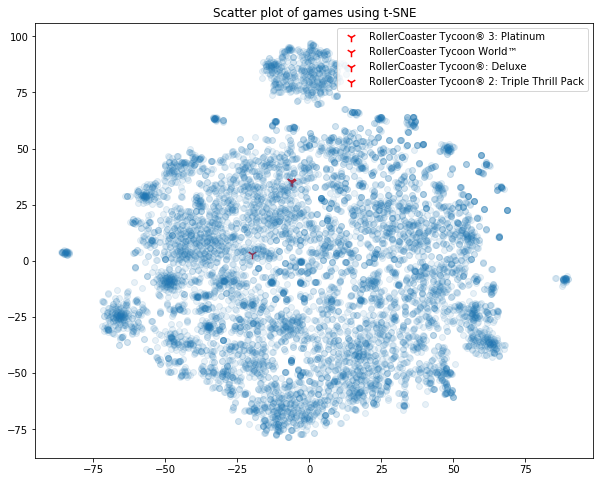

In [ ]:
# Set figsize
fig, ax = plt.subplots(figsize=(10,8))

Xlabeled = embeddings2d[match.index, 0]
Ylabeled = embeddings2d[match.index, 1]
labels = match['game'].values

# Scatter specific points
for x, y, label in zip(Xlabeled, Ylabeled, labels):
    ax.scatter(x, y, marker='1', label = label, s=90, color = 'red')

# Scatter points, set alpha low to make points translucent
ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.1)

plt.title('Scatter plot of games using t-SNE')
plt.legend()

plt.show()

### Recommendations for existing user

In [ ]:
# Get recommendations
rec_list_u12 = get_recs(model = mf_model, 
                    interactions = interactions, 
                    user_id = 5000, 
                    user_dict = user_dict,
                    item_dict = games_dict, 
                    threshold = 0,
                    num_items = 5,
                    show_known = True, 
                    show_recs = True)

Known Likes:
1- Dungeon Fighter Online
2- ESEA
3- H1Z1 Test Server
4- H1Z1
5- CS:GO Player Profiles
6- Just Survive Test Server
7- AdVenture Capitalist
8- Strife®
9- Dirty Bomb®
10- Game of Thrones - A Telltale Games Series
11- Don't Starve Together
12- Unturned
13- Robocraft
14- Mount Your Friends
15- Warface
16- Fistful of Frags
17- The Walking Dead: Season 2
18- Rust
19- Toribash
20- Heroes &amp; Generals
21- FEZ
22- No More Room in Hell
23- Cry of Fear
24- Insurgency
25- Hotline Miami
26- MapleStory
27- The Walking Dead
28- Castle Crashers®
29- Max Payne 3
30- Mount &amp; Blade: Warband
31- Super Meat Boy
32- Defence Alliance 2
33- TrackMania Nations Forever
34- BioShock Infinite
35- Just Cause 2
36- Garry's Mod
37- Killing Floor
38- Counter-Strike: Global Offensive
39- Left 4 Dead 2
40- Left 4 Dead
41- Half-Life 2: Episode Two
42- Portal
43- Half-Life 2: Episode One
44- Half-Life Deathmatch: Source
45- Half-Life 2: Lost Coast
46- Half-Life 2: Deathmatch
47- Counter-Strike: Source


These look reasonable, for instance we note the choice of sequels e.g. Portal 2 when user owns Portal.

### Create item embedding matrix

In [ ]:
item_dist = create_item_emdedding_matrix(model = mf_model,interactions = interactions)

In [ ]:
item_dist.shape

(8791, 8791)

In [ ]:
item_dist.head()

id,10,20,30,40,50,60,70,80,130,220,...,526790,527340,527440,527510,527520,527810,527890,527900,528660,530720
id,,,,,,,,,,,,,,,,,,,,,
10,1.000000,0.731529,0.879591,0.876051,0.706809,0.877243,0.695987,0.994726,0.708043,0.534097,...,-0.142010,-0.061042,-0.141748,-0.082000,-0.199971,-0.036513,-0.104426,-0.049059,0.026490,-0.037666
20,0.731529,1.000000,0.870352,0.871076,0.997211,0.867449,0.986764,0.693685,0.997679,0.850036,...,-0.214833,0.019705,-0.153746,-0.103405,-0.184007,-0.080695,-0.237645,-0.130851,-0.137446,-0.056457
30,0.879591,0.870352,1.000000,0.998455,0.860117,0.998377,0.823525,0.846423,0.858127,0.636772,...,-0.024800,-0.145306,-0.051361,0.040431,-0.078324,0.071165,-0.080929,0.032044,0.056749,0.077789
40,0.876051,0.871076,0.998455,1.000000,0.861195,0.999428,0.823521,0.840984,0.859179,0.634553,...,-0.017766,-0.143943,-0.050362,0.039730,-0.073733,0.071715,-0.071177,0.040820,0.053776,0.080377
50,0.706809,0.997211,0.860117,0.861195,1.000000,0.857806,0.989927,0.668041,0.999210,0.861634,...,-0.226207,0.000676,-0.147672,-0.104517,-0.183134,-0.086768,-0.245219,-0.144724,-0.147347,-0.064283


### Generate item recommendations

In [ ]:
# Similar items to item_id 10 - Counter Strike
item_rec_list_10 = get_item_recs(item_emdedding_matrix = item_dist, 
                              item_id = 10, 
                              item_dict = games_dict, 
                              n_items = 5, 
                              show = True)

Item of interest: Counter-Strike
Similar items:
1- Counter-Strike: Condition Zero
2- Day of Defeat
3- Ricochet
4- Deathmatch Classic
5- Counter-Strike: Source


In [ ]:
gamesdata[gamesdata['title'] == 'The Witness']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
5211,"Thekla, Inc.","['Adventure', 'Indie']",The Witness,The Witness,http://store.steampowered.com/app/210970/The_W...,2016-01-26,"['Puzzle', 'Exploration', 'First-Person', 'Sin...",NaN,http://steamcommunity.com/app/210970/reviews/?...,"['Single-player', 'Steam Achievements', 'Capti...",39.99,False,210970.0,"Thekla, Inc.",Very Positive,87.0


In [ ]:
# Similar items to item_id 210970 The Witness
item_rec_list_210970 = get_item_recs(item_emdedding_matrix = item_dist, 
                              item_id = 210970, 
                              item_dict = games_dict, 
                              n_items = 5, 
                              show = True)

Item of interest: The Witness
Similar items:
1- Headlander
2- Quadrilateral Cowboy
3- Overcooked
4- The Deadly Tower of Monsters
5- Oxenfree


In [ ]:
gamesdata[gamesdata['title'] == 'American Truck Simulator']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
24195,SCS Software,"['Indie', 'Simulation']",American Truck Simulator,American Truck Simulator,http://store.steampowered.com/app/270880/Ameri...,2016-02-02,"['Simulation', 'Driving', 'Open World', 'Ameri...",NaN,http://steamcommunity.com/app/270880/reviews/?...,"['Single-player', 'Steam Achievements', 'Steam...",19.99,False,270880.0,SCS Software,Very Positive,76.0


In [ ]:
# Similar items to item_id 270880 American Truck Simulator
item_rec_list_270880 = get_item_recs(item_emdedding_matrix = item_dist, 
                              item_id = 270880, 
                              item_dict = games_dict, 
                              n_items = 5, 
                              show = True)

Item of interest: American Truck Simulator
Similar items:
1- Farming Simulator 15
2- Bus Simulator 16
3- Automation - The Car Company Tycoon Game
4- OMSI 2: Steam Edition
5- BeamNG.drive


These look reasonable.

### Recommendations for new user - Demo

Example games owned:
* 210970 The Witness
* 288160 The Room
* 550 Left 4 Dead 2

In [ ]:
# Get list of owned games from user

# Create empty list to store game ids
ownedgames = []

# Create loop to prompt for game id and ask if want to continue
moretoadd = 'y'
while moretoadd == 'y':
    game = input('Please enter the game id: ')
    ownedgames.append(game)
    moretoadd = input('Do you have more games to add? y/n ')
    
# Print list of owned games
print(f"You own the following games: {ownedgames}")

Please enter the game id: 210970
Do you have more games to add? y/n y
Please enter the game id: 288160
Do you have more games to add? y/n y
Please enter the game id: 550
Do you have more games to add? y/n n
You own the following games: ['210970', '288160', '550']


## References

1. [https://www.kaggle.com/tamber/steam-video-games/data](https://www.kaggle.com/tamber/steam-video-games/data)
2. [https://github.com/nadinezab/video-game-recs](https://github.com/nadinezab/video-game-recs)
3. [https://medium.com/web-mining-is688-spring-2021/video-game-recommendation-system-b9bcb306bf16](https://medium.com/web-mining-is688-spring-2021/video-game-recommendation-system-b9bcb306bf16)
4. [https://audreygermain.github.io/Game-Recommendation-System/](https://audreygermain.github.io/Game-Recommendation-System/)
5. [https://github.com/annelovepeace/Game-Recommendation-System](https://github.com/annelovepeace/Game-Recommendation-System)
6. [https://library.ucsd.edu/dc/object/bb5021836n/_3_1.pdf](https://library.ucsd.edu/dc/object/bb5021836n/_3_1.pdf)
7. [https://github.com/manandesai/game-recommendation-engine](https://github.com/manandesai/game-recommendation-engine)
8. [https://towardsdatascience.com/steam-recommendation-systems-4358917288eb](https://towardsdatascience.com/steam-recommendation-systems-4358917288eb)
9. [https://github.com/AlbertNightwind/Steam-recommendation-system](https://github.com/AlbertNightwind/Steam-recommendation-system)
10. [https://steffy-lo.github.io/Gameo/docs/en/](https://steffy-lo.github.io/Gameo/docs/en/)
11. [https://gitlab.com/recommend.games](https://gitlab.com/recommend.games)
12. [Personalized Bundle Recommendation in Online Games](https://dl.acm.org/doi/10.1145/3340531.3412734)
13. [A Machine-Learning Item Recommendation System for Video Games](https://ieeexplore.ieee.org/document/8490456)
14. [Content Based Player and Game Interaction Model for Game Recommendation in the Cold Start setting](https://arxiv.org/abs/2009.08947)
15. [Intelligent Game Recommendation System](https://aip.scitation.org/doi/epdf/10.1063/5.0042063)
16. [The MARS – A Multi-Agent Recommendation System for Games on Mobile Phones](https://link.springer.com/chapter/10.1007/978-3-642-30947-2_14)
17. [A Machine-Learning Item Recommendation System for Video Games](https://arxiv.org/pdf/1806.04900.pdf)
18. [HybridRank : A Hybrid Content-Based Approach To Mobile Game Recommendations](http://ceur-ws.org/Vol-1245/cbrecsys2014-paper02.pdf)
19. [A Recommender System for Mobile Applications of Google Play Store](https://thesai.org/Downloads/Volume11No9/Paper_6-A_Recommender_System_for_Mobile_Applications.pdf)
20. [https://www.recombee.com/domains/online-gaming.html](https://www.recombee.com/domains/online-gaming.html)

## Appendix

### Expected features for a game recommendation system

1. **Adapting to your data:** A robust system that can utilize all data available to generate great recommendations for your users, including collaborative filtering and content-based models.
2. **Dynamically Retrained Models:** Real-time content personalization to meet the flourishing customer’s tastes and adaptation of newly added gaming content.
3. **Specific Functionalities to Online Gaming:** NLP recognizing texts in 80+ languages to analyze game attributes for an international clientele.
4. **AI-powered A/B Testing:** AutoML AI applied to keep maximal KPIs and advance the deep learning algorithm functions.
5. **Advanced Business Rules:** Boosters or filters to push forward desired games and easy to manipulate, adjustable rules for additional optimization of your content.
6. **Real AI Inside:** Reinforcement learning and other methods recommending desired games based on historical on-site behavior.